In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [4]:
def read_data():
    basedir = './prepped_data/'
    
    main_data_df = pd.read_csv(basedir + 'main_data_ver_2.4.csv')
    print(1)
    coor_df = pd.read_csv(basedir + 'coor_data_ver_1.csv')
    print(2)
    land_prices_df = pd.read_csv(basedir + 'land_prices_ver_1.csv')
    print(3)
    land_specs_df = pd.read_csv(basedir + 'land_specs_ver_2.csv')
    print(4)
    land_plans_df = pd.read_csv(basedir + 'land_plans_ver_2.csv')
    print(5)
    
    return main_data_df, coor_df, land_prices_df, land_specs_df, land_plans_df

In [5]:
%%time
main_data_df, coor_df, land_prices_df, land_specs_df, land_plans_df = read_data()

1
2
3
4
5
Wall time: 17.6 s


In [8]:
print(main_data_df.shape)
main_data_df.head()

(4559866, 16)


,지번주소,도로명주소,대장구분명,대장구분코드,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건축년도,건물나이,target_log_transformed,target/area_log_transformed
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_매매,77.75,57000,0,733.118971,2,2013,9,1988,25,10.950807,6.597308
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_매매,77.75,57000,0,733.118971,2,2013,12,1988,25,10.950807,6.597308
2,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3-0,일반,1,아파트_매매,67.28,55000,0,817.479191,5,2013,2,1987,26,10.915088,6.706225
3,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3-0,일반,1,아파트_매매,67.28,58250,0,865.784780,4,2013,2,1987,26,10.972499,6.763636
4,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3-0,일반,1,아파트_매매,67.28,60000,0,891.795482,5,2013,5,1987,26,11.002100,6.793237


In [10]:
merge1_df = main_data_df.merge(land_prices_df, on=['지번주소', '년'])
print(merge1_df.shape)
merge1_df.head()

(4405464, 19)


,지번주소,도로명주소,대장구분명,대장구분코드,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건축년도,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_매매,77.75,57000,0,733.118971,2,2013,9,1988,25,10.950807,6.597308,일반,9210000,N
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_매매,77.75,57000,0,733.118971,2,2013,12,1988,25,10.950807,6.597308,일반,9210000,N
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_전세,77.75,35000,0,450.160772,4,2013,1,1988,25,10.463103,6.109605,일반,9210000,N
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_전세,77.75,32000,0,411.575563,9,2013,3,1988,25,10.373491,6.019993,일반,9210000,N
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_전세,77.75,37000,0,475.884244,1,2013,9,1988,25,10.518673,6.165175,일반,9210000,N


In [16]:
merge1_df['대장구분코드'].value_counts()

1    4405464
Name: 대장구분코드, dtype: int64

In [12]:
land_specs_df.head()

,Unnamed: 0,지번주소,대장구분코드,년,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드
0,0,서울특별시 종로구 청운동 1-0,1,2006,8,15622.1,13,0,2,4,6
1,1,서울특별시 종로구 청운동 1-0,1,2007,8,15622.1,13,0,2,4,6
2,2,서울특별시 종로구 청운동 1-0,1,2008,8,15622.1,13,0,2,4,6
3,3,서울특별시 종로구 청운동 1-0,1,2009,8,15622.1,13,0,2,4,6
4,4,서울특별시 종로구 청운동 1-0,1,2010,8,15622.1,13,0,2,4,6


In [20]:
prac_df = land_specs_df[land_specs_df['지번주소'] == '서울특별시 종로구 청운동 1-0']
print(prac_df.shape)
prac_df.head()

(15, 11)


,Unnamed: 0,지번주소,대장구분코드,년,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드
0,0,서울특별시 종로구 청운동 1-0,1,2006,8,15622.1,13,0,2,4,6
1,1,서울특별시 종로구 청운동 1-0,1,2007,8,15622.1,13,0,2,4,6
2,2,서울특별시 종로구 청운동 1-0,1,2008,8,15622.1,13,0,2,4,6
3,3,서울특별시 종로구 청운동 1-0,1,2009,8,15622.1,13,0,2,4,6
4,4,서울특별시 종로구 청운동 1-0,1,2010,8,15622.1,13,0,2,4,6


In [17]:
land_specs_df = land_specs_df[land_specs_df['대장구분코드'] == 1].reset_index(drop=True)

In [22]:
land_specs_df['토지면적'].describe()

count    1.632405e+06
mean     8.258130e+02
std      5.245148e+03
min      1.000000e+00
25%      1.658000e+02
50%      2.165000e+02
75%      3.100000e+02
max      3.926520e+05
Name: 토지면적, dtype: float64

<AxesSubplot:>

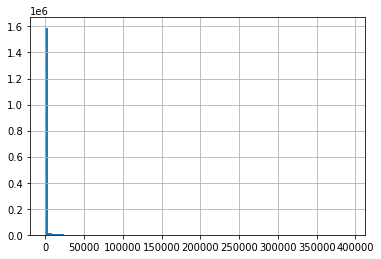

In [23]:
land_specs_df['토지면적'].hist(bins=100)

<AxesSubplot:>

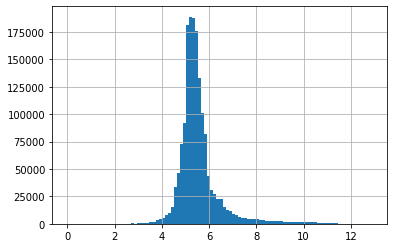

In [24]:
land_specs_df['토지면적'].apply(np.log).hist(bins=100)

In [18]:
merge1_df.drop(columns=['대장구분명', '대장구분코드'], inplace=True)

In [19]:
merge1_df.head()

,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건축년도,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_매매,77.75,57000,0,733.118971,2,2013,9,1988,25,10.950807,6.597308,일반,9210000,N
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_매매,77.75,57000,0,733.118971,2,2013,12,1988,25,10.950807,6.597308,일반,9210000,N
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_전세,77.75,35000,0,450.160772,4,2013,1,1988,25,10.463103,6.109605,일반,9210000,N
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_전세,77.75,32000,0,411.575563,9,2013,3,1988,25,10.373491,6.019993,일반,9210000,N
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_전세,77.75,37000,0,475.884244,1,2013,9,1988,25,10.518673,6.165175,일반,9210000,N


In [26]:
land_specs_df.drop(columns=['Unnamed: 0', '대장구분코드'], inplace=True)

In [27]:
land_specs_df.head()

,지번주소,년,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드
0,서울특별시 종로구 청운동 1-0,2006,8,15622.1,13,0,2,4,6
1,서울특별시 종로구 청운동 1-0,2007,8,15622.1,13,0,2,4,6
2,서울특별시 종로구 청운동 1-0,2008,8,15622.1,13,0,2,4,6
3,서울특별시 종로구 청운동 1-0,2009,8,15622.1,13,0,2,4,6
4,서울특별시 종로구 청운동 1-0,2010,8,15622.1,13,0,2,4,6


In [44]:
merge2_df = merge1_df.merge(land_specs_df, on=['지번주소', '년'])
print(merge2_df.shape)
merge2_df.head()

(4397723, 25)


,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건축년도,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,land_area_log
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_매매,77.75,57000,0,733.118971,2,2013,9,1988,25,10.950807,6.597308,일반,9210000,N,8,1168.3,15,0,2,3,3,7.063305
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_매매,77.75,57000,0,733.118971,2,2013,12,1988,25,10.950807,6.597308,일반,9210000,N,8,1168.3,15,0,2,3,3,7.063305
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_전세,77.75,35000,0,450.160772,4,2013,1,1988,25,10.463103,6.109605,일반,9210000,N,8,1168.3,15,0,2,3,3,7.063305
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_전세,77.75,32000,0,411.575563,9,2013,3,1988,25,10.373491,6.019993,일반,9210000,N,8,1168.3,15,0,2,3,3,7.063305
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,아파트_전세,77.75,37000,0,475.884244,1,2013,9,1988,25,10.518673,6.165175,일반,9210000,N,8,1168.3,15,0,2,3,3,7.063305


In [45]:
basedir = './feature_maps/'
trade_type_map_df = pd.read_csv(basedir + 'trade_type_map.csv')
special_land_map_df = pd.read_csv(basedir + 'special_land_map.csv')
standard_land_map_df = pd.read_csv(basedir + 'standard_land_map.csv')

In [52]:
trade_type_map = trade_type_map_df.to_dict(orient='records')[0]
special_land_map = special_land_map_df.to_dict(orient='records')[0]
standard_land_map = standard_land_map_df.to_dict(orient='records')[0]

In [54]:
merge2_df['trade_type'] = merge2_df['trade_type'].map(trade_type_map)
merge2_df['특수지구분명'] = merge2_df['특수지구분명'].map(special_land_map)
merge2_df['표준지여부'] = merge2_df['표준지여부'].map(standard_land_map)

In [55]:
merge2_df.head()

,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건축년도,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,land_area_log
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,2013,9,1988,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,2013,12,1988,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,0,450.160772,4,2013,1,1988,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,0,411.575563,9,2013,3,1988,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,0,475.884244,1,2013,9,1988,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305


In [56]:
merge2_df.drop(columns=['건축년도'], inplace=True)
merge2_df.head()

,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,land_area_log
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,2013,9,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,2013,12,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,0,450.160772,4,2013,1,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,0,411.575563,9,2013,3,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,0,475.884244,1,2013,9,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305


In [57]:
merge2_df['year_linear'] = (merge2_df['년'] - merge2_df['년'].min()) + ((merge2_df['월']-1)/12)

In [59]:
merge2_df.head()

,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,land_area_log,year_linear
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,2013,9,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.666667
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,2013,12,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.916667
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,0,450.160772,4,2013,1,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.000000
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,0,411.575563,9,2013,3,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.166667
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,0,475.884244,1,2013,9,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.666667


In [60]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [61]:
merge2_df['month_sin'] = merge2_df['월'].apply(month_circular_sine_func)
merge2_df['month_cos'] = merge2_df['월'].apply(month_circular_cosine_func)

In [62]:
merge2_df.drop(columns=['년', '월'], inplace=True)

In [66]:
merge2_df['시'] = merge2_df['지번주소'].apply(lambda x: x.split(' ')[1])
merge2_df['동'] = merge2_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [67]:
merge2_df.head()

,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,land_area_log,year_linear,month_sin,month_cos,시,동
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.666667,-0.866025,-0.500000,강남구,개포동
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.916667,-0.500000,0.866025,강남구,개포동
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.000000,0.000000,1.000000,강남구,개포동
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.166667,0.866025,0.500000,강남구,개포동
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.666667,-0.866025,-0.500000,강남구,개포동


In [69]:
si_map_df = pd.DataFrame({'시':merge2_df['시'].unique(), 'map':[i for i in range(len(merge2_df['시'].unique()))]})
si_map_df.to_csv('si_map.csv', index=False)
si_map = {}
for i in range(si_map_df.shape[0]):
    si_map[si_map_df['시'][i]] = si_map_df['map'][i]
    
print(len(si_map))
si_map

25


{'강남구': 0,
 '강동구': 1,
 '강북구': 2,
 '강서구': 3,
 '관악구': 4,
 '광진구': 5,
 '구로구': 6,
 '금천구': 7,
 '노원구': 8,
 '도봉구': 9,
 '동대문구': 10,
 '동작구': 11,
 '마포구': 12,
 '서대문구': 13,
 '서초구': 14,
 '성동구': 15,
 '성북구': 16,
 '송파구': 17,
 '양천구': 18,
 '영등포구': 19,
 '용산구': 20,
 '은평구': 21,
 '종로구': 22,
 '중구': 23,
 '중랑구': 24}

In [71]:
def get_dong(x):
    #x is a string
    
    for i in range(10):
        splitted = x.split('{}'.format(i))
        if len(splitted) > 1:
            return splitted[0]
    
    return x

In [72]:
merge2_df['동2'] = merge2_df['동'].apply(get_dong)

In [74]:
merge2_df['동'] = merge2_df['동2']

In [75]:
merge2_df.drop(columns=['동2'], inplace=True)

In [76]:
dong_map_df = pd.DataFrame({'동':merge2_df['동'].unique(), 'map':[i for i in range(len(merge2_df['동'].unique()))]})
dong_map_df.to_csv('dong_map.csv', index=False)
dong_map = {}
for i in range(dong_map_df.shape[0]):
    dong_map[dong_map_df['동'][i]] = dong_map_df['map'][i]

print(len(dong_map))
dong_map

315


{'개포동': 0,
 '논현동': 1,
 '대치동': 2,
 '도곡동': 3,
 '삼성동': 4,
 '세곡동': 5,
 '수서동': 6,
 '신사동': 7,
 '압구정동': 8,
 '역삼동': 9,
 '일원동': 10,
 '청담동': 11,
 '강일동': 12,
 '고덕동': 13,
 '길동': 14,
 '둔촌동': 15,
 '명일동': 16,
 '상일동': 17,
 '성내동': 18,
 '암사동': 19,
 '천호동': 20,
 '미아동': 21,
 '번동': 22,
 '수유동': 23,
 '우이동': 24,
 '가양동': 25,
 '공항동': 26,
 '내발산동': 27,
 '등촌동': 28,
 '마곡동': 29,
 '방화동': 30,
 '염창동': 31,
 '화곡동': 32,
 '남현동': 33,
 '봉천동': 34,
 '신림동': 35,
 '광장동': 36,
 '구의동': 37,
 '군자동': 38,
 '능동': 39,
 '자양동': 40,
 '중곡동': 41,
 '화양동': 42,
 '가리봉동': 43,
 '개봉동': 44,
 '고척동': 45,
 '구로동': 46,
 '궁동': 47,
 '신도림동': 48,
 '오류동': 49,
 '온수동': 50,
 '천왕동': 51,
 '항동': 52,
 '가산동': 53,
 '독산동': 54,
 '시흥동': 55,
 '공릉동': 56,
 '상계동': 57,
 '월계동': 58,
 '중계동': 59,
 '하계동': 60,
 '도봉동': 61,
 '방학동': 62,
 '쌍문동': 63,
 '창동': 64,
 '답십리동': 65,
 '신설동': 66,
 '용두동': 67,
 '이문동': 68,
 '장안동': 69,
 '전농동': 70,
 '제기동': 71,
 '청량리동': 72,
 '회기동': 73,
 '휘경동': 74,
 '노량진동': 75,
 '대방동': 76,
 '동작동': 77,
 '본동': 78,
 '사당동': 79,
 '상도': 80,
 '상도동': 81,
 '신대방동': 82,
 '흑석동': 83,
 '

In [77]:
merge2_df['si_mapped'] = merge2_df['시'].map(si_map)
merge2_df['dong_mapped'] = merge2_df['동'].map(dong_map)
merge2_df.drop(columns=['시', '동'], inplace=True)
print(merge2_df.shape)
merge2_df.head()

(4397723, 27)


,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가,표준지여부,지목코드,토지면적,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,land_area_log,year_linear,month_sin,month_cos,si_mapped,dong_mapped
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.666667,-0.866025,-0.500000,0,0
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,0,733.118971,2,25,10.950807,6.597308,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.916667,-0.500000,0.866025,0,0
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,0,450.160772,4,25,10.463103,6.109605,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.000000,0.000000,1.000000,0,0
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,0,411.575563,9,25,10.373491,6.019993,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.166667,0.866025,0.500000,0,0
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,0,475.884244,1,25,10.518673,6.165175,1,9210000,0,8,1168.3,15,0,2,3,3,7.063305,7.666667,-0.866025,-0.500000,0,0


In [79]:
merge2_df.to_csv('training_data_ver_3.csv', index=False)

In [ ]:
cat_cols = ['trade_type', '층', '건물나이', '특수지구분명', '표준지여부', '지목코드'] + land_specs_df.columns[5:].tolist() + land_plans_df.columns[3:].tolist()
cat_cols

In [ ]:
cat_cols_df = pd.DataFrame({'cat_cols':cat_cols})
cat_cols_df

In [ ]:
cat_cols_df.to_csv('cat_cols.csv', index=False)

In [ ]:
merge5_df.to_csv('training_data_ver_2.csv', index=False)